<a href="https://colab.research.google.com/github/Waynsday/Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **SETUP**
Includes library imports, path definitions

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip3 install pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-y3ncuh4w/pytorch_15d13763ad1242608d80ee652b064907/setup.py'"'"'; __file__='"'"'/tmp/pip-install-y3ncuh4w/pytorch_15d13763ad1242608d80ee652b064907/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-rgf8xrpi/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs f

In [ ]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from google.colab import drive
import os

import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
drive.mount("/content/gdrive")
path = '/content/gdrive/My Drive/THESIS_DATASET'

img_dir = os.path.join(path, 'DATASET')
annotations_file = os.path.join(path, 'annotation_labels.csv')

Mounted at /content/gdrive


#### **Defining the Dataset Class**

In [ ]:
class WaDaBaDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx,1]))
    image = read_image(img_path)
    label = self.img_labels.iloc[idx,2]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

In [ ]:
img_labels = pd.read_csv(annotations_file)
img_labels.iloc[2068, 1]

'0079_a01b00c2d0e0f1g0h3.jpg'

In [ ]:
## transformations

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(),transforms.ToTensor(), transforms.Normalize(mean, std)])

#### Exploring the Dataset and defining train and test sets

In [ ]:
dataset = WaDaBaDataset(annotations_file, img_dir, transform)
val_size = int(len(dataset)*.2)
train_size = len(dataset) - val_size
training_data, test_data = random_split(dataset, [train_size,val_size], generator=torch.Generator().manual_seed(42))

dataset_sizes = {'train': train_size, 'val': val_size}

In [ ]:
BATCH_SIZE = 4

from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle= True)

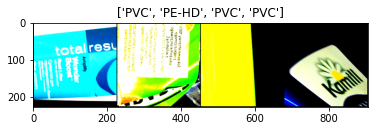

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['PETE', 'PE-HD', 'PVC', 'PE-LD', 'PP', 'PS', 'Other']


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = inp / 2 + 0.5
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## functions to show an image
#def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
#dataiter = iter(train_dataloader)
#images, labels = dataiter.next()

## show images
#imshow(torchvision.utils.make_grid(images))

In [ ]:
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([4, 3, 224, 224])
Image label dimensions: torch.Size([4])


### **Creating the Model**

In [ ]:
import time
import copy

dataloaders ={'train': train_dataloader, 'val': test_dataloader}
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
from torchvision.models import mobilenet_v2, resnet50, ResNet50_Weights, MobileNet_V2_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-71bc882c-1cc0-f260-a075-c07f6b49bb57)


In [ ]:
learning_rate = 0.001
num_epochs = 20

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs)

Epoch 0/19
----------
train Loss: 1.3686 Acc: 0.6026
val Loss: 1.0625 Acc: 0.6408

Epoch 1/19
----------
train Loss: 0.8010 Acc: 0.7076
val Loss: 0.7868 Acc: 0.7092

Epoch 2/19
----------
train Loss: 0.6745 Acc: 0.7428
val Loss: 0.7062 Acc: 0.7355

Epoch 3/19
----------
train Loss: 0.5928 Acc: 0.7806
val Loss: 0.6795 Acc: 0.7487

Epoch 4/19
----------
train Loss: 0.5462 Acc: 0.7944
val Loss: 0.5642 Acc: 0.7974

Epoch 5/19
----------
train Loss: 0.4887 Acc: 0.8148
val Loss: 0.5284 Acc: 0.8184

Epoch 6/19
----------
train Loss: 0.4147 Acc: 0.8480
val Loss: 0.4746 Acc: 0.8329

Epoch 7/19
----------
train Loss: 0.3497 Acc: 0.8806
val Loss: 0.4235 Acc: 0.8342

Epoch 8/19
----------
train Loss: 0.3159 Acc: 0.8862
val Loss: 0.4126 Acc: 0.8461

Epoch 9/19
----------
train Loss: 0.3033 Acc: 0.8993
val Loss: 0.4253 Acc: 0.8566

Epoch 10/19
----------
train Loss: 0.2872 Acc: 0.9043
val Loss: 0.4040 Acc: 0.8474

Epoch 11/19
----------
train Loss: 0.2959 Acc: 0.8967
val Loss: 0.3864 Acc: 0.8553

Ep

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
class_names = ['PETE', 'PE-HD', 'PVC', 'PE-LD', 'PP', 'PS', 'Other']

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.float().to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.int().cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

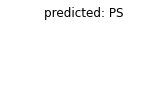

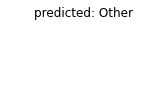

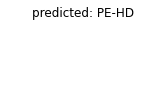

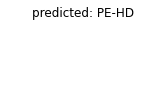

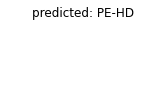

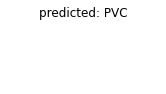

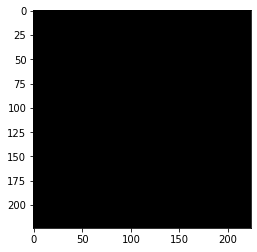

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft, 'mobilenetv2-model3.pth')

In [ ]:
model = torch.load('mobilenetv2-model3.pth')
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

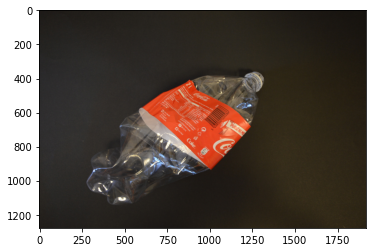

In [ ]:
im = '0001_a01b00c1d2e0f0g1h0.jpg'


from torch.autograd import Variable
from PIL import Image
def process_image(image):
  preprocess = transform
  image = preprocess(image)
  return image

def imshow(image, ax=None, title=None):
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1,2,0))

  image = np.clip(image, 0, 1)

  ax.imshow(image)

  return ax

with Image.open(im) as image:
  plt.imshow(image)

In [ ]:

img_transform = transforms.Compose(
    [transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()])

img = Image.open(im)
img = img_transform(img).to(device)
img = torch.unsqueeze(img,0)

model.eval()
prediction = F.softmax(model(img), dim =1)
prediction = prediction.argmax()
prediction


tensor(1, device='cuda:0')